In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data_1308.csv", index_col="Unnamed: 0")
df.head()

,Şəhər,Sürətlər qutusu,Marka,Ötürücü,Model,Yeni,Buraxılış ili,Yürüş,Yerlərin sayı,Ban növü,...,Oturacaqların ventilyasiyası,ABS,Park radarı,Ksenon lampalar,Lyuk,Kondisioner,Arxa görüntü kamerası,Yağış sensoru,Oturacaqların isidilməsi,Yan pərdələr
1,Bakı,Avtomat,Mercedes,Tam,G 63 AMG,Xeyr,2019,21000,5,Offroader,...,True,True,True,True,True,True,True,True,True,False
2,Bakı,Avtomat,Hyundai,Ön,Grandeur,Bəli,2023,0,5,Sedan,...,True,True,True,True,True,True,True,False,True,False
3,Bakı,Avtomat,Mercedes,Tam,GLS 450 4MATIC,Xeyr,2021,39000,5,Offroader,...,False,False,False,False,False,False,False,False,False,False
4,Bakı,Avtomat,Voyah,Tam,Free,Bəli,2024,0,5,Offroader,...,False,False,False,False,False,False,False,False,False,False
5,Bakı,Avtomat,Volkswagen,Ön,Jetta,Xeyr,2016,215652,4,Sedan,...,False,False,False,False,False,False,False,False,False,False


In [3]:
df = df.drop_duplicates()
df.shape

(5702, 31)

In [4]:
df_luxury = df[df["price"] > 115000]

In [5]:
df_normal = df.drop(df_luxury.index, axis=0)

In [6]:
data = df_normal
data.shape

(5341, 31)

In [7]:
cat_col = list(data.select_dtypes(exclude=["int64", "float64"]).columns)
num_col = list( data.select_dtypes(include=["int64", "float64"]).columns)

In [8]:
cat_col.remove("Model")

In [9]:
data = data[num_col+cat_col]

In [10]:
necessary_cat_col = ["Marka", "Ötürücü", "Sürətlər qutusu", "Ban növü", "Dəri salon", "Yanacaq",
                    "Oturacaqların ventilyasiyası", "Avtosalon", "Lyuk"]

In [11]:
data["Ban növü"].apply(lambda x: data.drop(data[data["Ban növü"] == x].index[0], axis=0, inplace=True) if x == "Motosiklet"
                       else (data.drop(data[data["Ban növü"] == x].index[0], axis=0, inplace=True) if x == "Kvadrosikl"
                        else(data.drop(data[data["Ban növü"] == x].index[0], axis=0, inplace=True) if x == "Moped"
                             else x)))

2              Sedan
4         Offroader 
5              Sedan
6         Offroader 
7              Sedan
            ...     
14801          Sedan
14802          Sedan
14803     Offroader 
14804    Universal, 
14805    Universal, 
Name: Ban növü, Length: 5341, dtype: object

In [12]:
final_df = data[num_col + necessary_cat_col]

In [13]:
final_df["category"] = final_df["price"].apply(lambda x: "Low" if x < 30000 else ("Middle" if x >= 30000 and x < 100000 else "Luxury"))

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x2000 with 0 Axes>

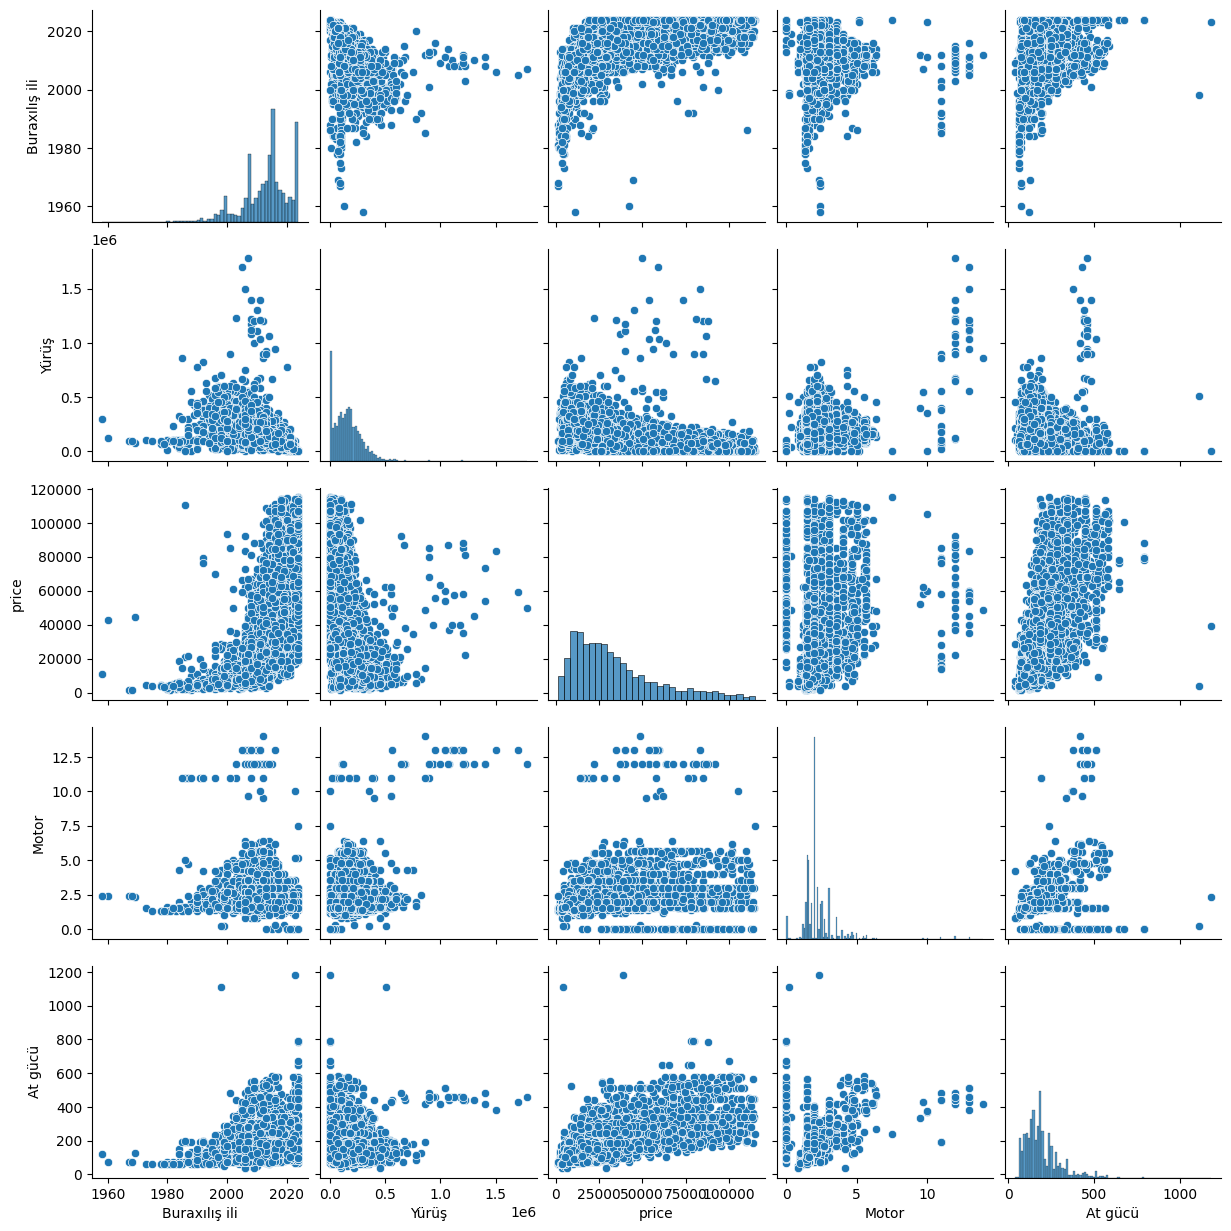

In [14]:
plt.figure(figsize=(20,20))
sns.pairplot(final_df[num_col])
plt.show

In [15]:
num_col.remove("price")

In [16]:
y = final_df["price"]
X = final_df.drop("price", axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=final_df["category"], random_state=42)

In [18]:
X_train

,Buraxılış ili,Yürüş,Motor,At gücü,Marka,Ötürücü,Sürətlər qutusu,Ban növü,Dəri salon,Yanacaq,Oturacaqların ventilyasiyası,Avtosalon,Lyuk,category
4660,2023,0,1.5,173.0,MG,Ön,Avtomat,Sedan,True,Benzin,False,Yes,True,Middle
13032,2009,201480,1.4,90.0,Opel,Ön,Mexaniki,"Hetçbek,",False,Benzin,False,No,False,Low
13924,2010,250000,1.8,99.0,Toyota,Ön,Variator,Liftbek,False,Hibrid,False,Yes,True,Low
6255,2015,114000,2.0,184.0,Mercedes,Arxa,Avtomat,Sedan,True,Benzin,True,No,False,Middle
3536,2019,54000,3.0,340.0,BMW,Tam,Avtomat,Offroader,False,Benzin,False,No,False,Middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7450,1996,349000,2.5,170.0,BMW,Ön,Avtomat,Sedan,True,Benzin,False,No,False,Low
3860,2018,123000,2.5,202.0,Toyota,Ön,Avtomat,Sedan,True,Benzin,False,No,True,Middle
7861,2015,150000,3.0,340.0,Land Rover,Tam,Avtomat,Offroader,True,Benzin,True,No,True,Middle
13137,1996,26000,1.5,65.0,LADA (VAZ),Arxa,Mexaniki,Sedan,False,Benzin,False,No,False,Low


In [19]:
y_train

4660     39499.5
13032    11700.0
13924    17800.0
6255     39610.0
3536     98600.0
          ...   
7450      7500.0
3860     45390.0
7861     67830.0
13137     3000.0
1233     46300.0
Name: price, Length: 4239, dtype: float64

In [20]:
preprocessor = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), num_col),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False, drop="first"), necessary_cat_col)
    ]
)

In [21]:
preprocessing_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor)
])

In [22]:
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

In [23]:
# Get the feature names from the ColumnTransformer
categorical_encoder = preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['cat']
onehot_encoded_cols = categorical_encoder.get_feature_names_out(necessary_cat_col)

# Combine the numerical columns with the one-hot encoded column names
all_feature_names = list(num_col) + list(onehot_encoded_cols)

X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names, index=X_train.index)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names, index=X_test.index)

# Check the transformed DataFrame
(X_test_preprocessed_df.head())


,Buraxılış ili,Yürüş,Motor,At gücü,Marka_Acura,Marka_Alfa Romeo,Marka_Audi,Marka_Avatr,Marka_BMW,Marka_BMW Alpina,...,Ban növü_Yük maşını,Dəri salon_True,Yanacaq_Dizel,Yanacaq_Elektro,Yanacaq_Hibrid,Yanacaq_Plug-in Hibrid,Yanacaq_Qaz,Oturacaqların ventilyasiyası_True,Avtosalon_Yes,Lyuk_True
1328,0.012481,-0.105248,-0.491587,-0.725430,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7924,0.762945,-0.737510,-0.033315,0.042230,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
10375,-0.362751,0.488452,-0.186073,-0.469543,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13367,0.262636,-0.531492,-0.415209,-1.158469,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4804,0.512790,-0.069728,-0.186073,0.662263,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [39]:
# rfc = RandomForestRegressor(n_estimators=300, random_state=42)
# rfc.fit(X_train_preprocessed_df, y_train)

# rfe = RFE(estimator=rfc, n_features_to_select=40)
# rfe.fit(X_train_preprocessed_df, y_train)

In [40]:
# X_test_preprocessed_df.columns[rfe.support_]

In [41]:
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
# xgb_model.fit(X_train_preprocessed_df, y_train)

# rfe_xgb = RFE(estimator=xgb_model, n_features_to_select=40)
# rfe_xgb.fit(X_train_preprocessed_df, y_train)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None, gamma=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=None, n_jobs=None,
                           num_parallel_tree=None, random_state=None, ...),
    n_features_to_select=40)

In [24]:
# X_train_preprocessed_df.columns[rfe.support_]

In [43]:
rfe_col_rfr = ['Buraxılış ili', 'Yürüş', 'Motor', 'At gücü', 'Marka_Audi', 'Marka_BMW',
       'Marka_BYD', 'Marka_Chevrolet', 'Marka_Ford', 'Marka_Haval',
       'Marka_Hyundai', 'Marka_Infiniti', 'Marka_Jetour', 'Marka_Kia',
       'Marka_KrAZ', 'Marka_LADA (VAZ)', 'Marka_Land Rover', 'Marka_Lexus',
       'Marka_Li Auto', 'Marka_Mercedes', 'Marka_Tesla', 'Marka_Toyota',
       'Marka_Volvo', 'Marka_ZEEKR', 'Ötürücü_Tam', 'Ötürücü_Ön',
       'Sürətlər qutusu_Mexaniki', 'Sürətlər qutusu_Reduktor',
       'Ban növü_Liftbek', 'Ban növü_Minivan', 'Ban növü_Offroader ',
       'Ban növü_Sedan', 'Ban növü_Yük maşını', 'Dəri salon_True',
       'Yanacaq_Dizel', 'Yanacaq_Hibrid', 'Yanacaq_Plug-in Hibrid',
       'Oturacaqların ventilyasiyası_True', 'Avtosalon_Yes', 'Lyuk_True']

In [25]:
rfe_col_xgb = ['Buraxılış ili', 'Yürüş', 'Motor', 'At gücü', 'Marka_Audi',
       'Marka_Avatr', 'Marka_BMW', 'Marka_BYD', 'Marka_Changan',
       'Marka_Chevrolet', 'Marka_Fiat', 'Marka_Ford', 'Marka_Haval',
       'Marka_Hyundai', 'Marka_Infiniti', 'Marka_KamAz', 'Marka_Kia',
       'Marka_KrAZ', 'Marka_LADA (VAZ)', 'Marka_Land Rover', 'Marka_Lexus',
       'Marka_Li Auto', 'Marka_Mercedes', 'Marka_Nissan', 'Marka_Subaru',
       'Marka_Tesla', 'Marka_Toyota', 'Marka_UAZ', 'Marka_ZEEKR',
       'Ötürücü_Tam', 'Ötürücü_Ön', 'Sürətlər qutusu_Mexaniki',
       'Ban növü_Dartqı', 'Ban növü_Kupe', 'Ban növü_Minivan',
       'Ban növü_Offroader ', 'Ban növü_Sedan', 'Yanacaq_Dizel',
       'Yanacaq_Hibrid', 'Lyuk_True']

In [40]:
joblib.dump(rfe_col_xgb, "necessary_columns.joblib")

['necessary_columns.joblib']

In [26]:
x_train_rfe_xgb = X_train_preprocessed_df[rfe_col_xgb]
x_test_rfe_xgb = X_test_preprocessed_df[rfe_col_xgb]

In [49]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2]  # L2 regularization
}

# GridSearchCV for XGBoost
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(x_train_rfe_xgb, y_train)

# View the best parameters
print("Best Hyperparameters for XGBoost:", grid_search.best_params_)


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best Hyperparameters for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 0.7}


In [37]:
# # Use the best estimator
# best_rf = grid_search.best_estimator_

# # Fit the model
# best_rf.fit(x_train_rfe_xgb, y_train)

# # Make predictions
# y_pred_train = best_rf.predict(x_train_rfe_xgb)
# y_pred_test = best_rf.predict(x_test_rfe_xgb)

# # Evaluate the model
# from sklearn.metrics import mean_squared_error, r2_score

# print(f"Train R^2: {r2_score(y_train, y_pred_train)}")
# print(f"Test R^2: {r2_score(y_test, y_pred_test)}")
# print(f"Train RMSE: {mean_squared_error(y_train, y_pred_train, squared=False)}")
# print(f"Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")


In [35]:
final_model = xgb.XGBRegressor(colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=250,
                               reg_alpha=0.1, reg_lambda=1.5, subsample=0.7)
final_model.fit(x_train_rfe_xgb, y_train)

# Make predictions
y_pred_train = final_model.predict(x_train_rfe_xgb)
y_pred_test = final_model.predict(x_test_rfe_xgb)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

print(f"Train R^2: {r2_score(y_train, y_pred_train)}")
print(f"Test R^2: {r2_score(y_test, y_pred_test)}")
print(f"Train RMSE: {mean_squared_error(y_train, y_pred_train, squared=False)}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")

Train R^2: 0.9824070764153807
Test R^2: 0.9069954780377385
Train RMSE: 3277.042637878207
Test RMSE: 7821.232903737517


In [39]:
joblib.dump(final_model, "final_model.joblib")

['final_model.joblib']

In [44]:
x_train_rfe_rfr = X_train_preprocessed_df[rfe_col]
x_test_rfe_rfr = X_test_preprocessed_df[rfe_col]

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 500],           # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],      # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30, 40, 50],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],               # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],                 # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]                     # Whether to use bootstrap samples
}

# Implement RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                               n_iter=100, cv=5, verbose=2, 
                               random_state=42, n_jobs=-1)

# Fit the model
rf_random.fit(x_train_rfe_rfr, y_train)

# View the best parameters
print("Best Hyperparameters:", rf_random.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
# Use the best estimator
best_rf = rf_random.best_estimator_

# Fit the model
best_rf.fit(x_train_rfe_rfr, y_train)

# Make predictions
y_pred_train = best_rf.predict(x_train_rfe_rfr)
y_pred_test = best_rf.predict(x_test_rfe_rfr)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

print(f"Train R^2: {r2_score(y_train, y_pred_train)}")
print(f"Test R^2: {r2_score(y_test, y_pred_test)}")
print(f"Train RMSE: {mean_squared_error(y_train, y_pred_train, squared=False)}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")


Train R^2: 0.9978945062025526
Test R^2: 0.9024872582603254
Train RMSE: 1133.6789090035286
Test RMSE: 8008.549606445692


In [45]:
X_train["Marka"].unique()

array(['MG', 'Opel', 'Toyota', 'Mercedes', 'BMW', 'LADA (VAZ)', 'Hyundai',
       'Chevrolet', 'Fiat', 'Peugeot', 'Honda', 'KamAz', 'Kia',
       'Land Rover', 'Jeep', 'Lexus', 'Ford', 'Hongqi', 'Audi', 'GAC',
       'BYD', 'Volkswagen', 'Mitsubishi', 'Renault', 'Avatr', 'Changan',
       'ZEEKR', 'Mazda', 'GAZ', 'Nissan', 'MAN', 'Subaru', 'Voyah',
       'Bestune', 'DAF', 'Maple', 'Daewoo', 'Chery', 'Maserati', 'Volvo',
       'Baic', 'Wuling', 'Porsche', 'Infiniti', 'Suzuki', 'Khazar', 'GMC',
       'Haval', 'Li Auto', 'ROX (Polar Stone)', 'Mini', 'Smart', 'Tesla',
       'BMW Alpina', 'Saipa', 'Geely', 'Ssang Yong', 'Acura', 'Genesis',
       'Lynk & Co', 'Skoda', 'Dodge', 'Dayun', 'Iran Khodro', 'Forthing',
       'GWM', 'Isuzu', 'Citroen', 'Cadillac', 'Scania', 'Neta', 'DFSK',
       'VGV', 'Jaguar', 'DongFeng', 'ZX Auto', 'Tofas', 'SEAT', 'UAZ',
       'HOWO', 'KrAZ', 'XPeng', 'Leapmotor', 'Alfa Romeo', 'Ravon',
       'Abarth', 'JAC', 'Karry', 'IM', 'FAW', 'KG Mobility', 'Jetour